In [1]:
#import main libraries (numpy for data and matplotlib for plotting)
import numpy as np 
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

c:\Users\KimGiHu\KAERI-intership\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

#User parameters
features=['A+IGBT-I', 'A+*IGBT-I', 'B+IGBT-I', 'B+*IGBT-I', 'C+IGBT-I', 'C+*IGBT-I', 'A-FLUX', 
          'B-FLUX', 'C-FLUX', 'MOD-V', 'MOD-I', 'CB-I', 'CB-V', 'DV/DT']  # waveform names to use as a header
feature_index=6  # A-flux waveform (for plotting). Use 0 for A+IGBT-I, 1 for A+*IGBT-I, and so on.
system='RFQ'     # pick a system to load and plot. Choose RFQ, DTL, CCL, or SCL

In [3]:
#load both waveform (X) and labels (Y) datasets for an HVCM module, e.g. RFQ, DTL, CCL, SCL
X= np.load('./hvcm/hvcm/%s.npy'%system)   #---> X array has shape: (pulses, times, features)
Y=np.load('./hvcm/hvcm/%s_labels.npy'%system, allow_pickle=True)  #---> Y array has shape: (pulses, labels) --> labels are: index, state, type
time=np.arange(X.shape[1]) * 400e-9    #create time axis based on the sampling rate 400 ns (for plotting purposes)

In [4]:
print(X.shape)
print(Y.shape)
print(Y[1])
print(Y[690])

(872, 4500, 14)
(872, 3)
['./RFQ/RFQ_400ns_12_Hour_Run_3.12.2022-6.23.59AM.csv' 'Run' 'Normal']
['./RFQ/RFQ_400ns_Fault_1.11.2022-4.48.40PM.csv' 'Fault' 'TPS Fault']


In [4]:
# Split X/Y arrays into fault and normal data

#obtain array indices to split normal and fault data using the second column in Y """
fault_indices, normal_indices=np.where(Y[:,1] == 'Fault')[0], np.where(Y[:,1] == 'Run')[0]

In [92]:
print(fault_indices[:-150])

[690 691 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707
 708 709 710 711 712 713 714 715 716 717 718 719 720 721]


In [90]:
print(normal_indices[:-200])

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [5]:
#Use the indices to assign normal data to `Xnormal` and fault data to `Xanomaly` 
Xnormal, Xanomaly = X[normal_indices,:,:], X[fault_indices,:,:]

In [9]:
print(Xnormal.shape)
print(Xanomaly.shape)

(690, 4500, 14)
(182, 4500, 14)


In [6]:
#Use the indices to assign the labels of normal data to `Ynormal` and fault labels to `Yanomaly` 
Ynormal, Yanomaly = Y[normal_indices,:], Y[fault_indices,:]   #labels are: index, state, type

In [11]:
print(Ynormal.shape)
print(Yanomaly.shape)

(690, 3)
(182, 3)


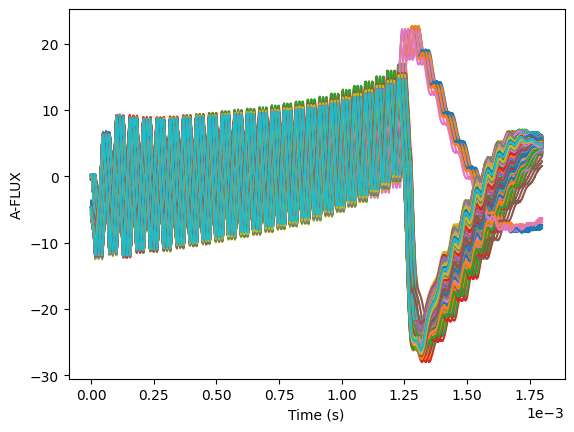

In [7]:
#plot normal pulses
#------------------------
plt.figure()
#loop over all normal pulses and plot the waveform given by feature_index
for i in range(Xnormal.shape[0]):   
    plt.plot(time, Xnormal[i,:,feature_index])   #plot A-flux normal
    # if i == 9 :
    #     break

plt.xlabel('Time (s)')  #add x-label
plt.ylabel(features[feature_index])  #add y-label
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0)) #use sci notation
plt.show()  #show the plot

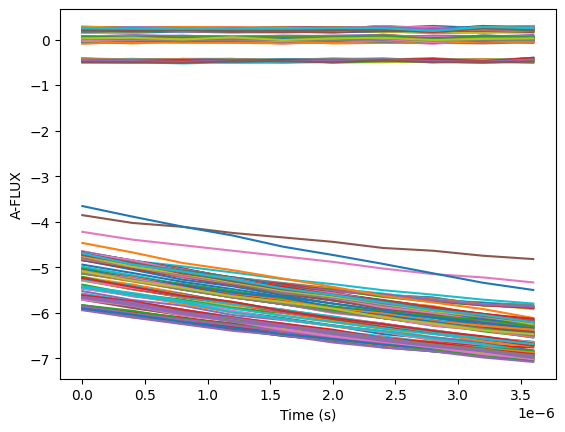

In [8]:
#plot normal pulses
#------------------------
plt.figure()
#loop over all normal pulses and plot the waveform given by feature_index
for i in range(Xnormal.shape[0]):   
    plt.plot(time[:10], Xnormal[i,:10,feature_index])   #plot A-flux normal
    # if i == 9 :
    #     break

plt.xlabel('Time (s)')  #add x-label
plt.ylabel(features[feature_index])  #add y-label
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0)) #use sci notation
plt.show()  #show the plot

In [9]:
# GPU 장치 정의

device = torch.device("cuda", index=0)

In [10]:
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

In [11]:
class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        output = self.linear(lstm_out)

        return output, self.hidden

In [12]:
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs

    def predict(self, inputs, target_len):
        inputs = inputs.unsqueeze(0)
        self.eval()
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

In [13]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [31]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

In [35]:
train = min_max_scaler.fit_transform(Xanomaly[0,:,feature_index].reshape(-1,1))

In [36]:
train.shape

(4500, 1)

In [53]:
train = train.flatten()

In [54]:
train.shape

(4500,)

In [48]:
Xanomaly[0,:,feature_index].shape

(4500,)

In [55]:
iw = 100*8
ow = 100*2

train_dataset = windowDataset(train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)
# y_train_loader = DataLoader(y_train, batch_size=5)

In [78]:
model = lstm_encoder_decoder(input_size=1, hidden_size=16).to(device)

In [79]:
learning_rate=0.001
epoch = 30
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [80]:
predict = model.predict(torch.tensor(train_dataset[0][0]).to(device).float(), target_len=ow)
real = train_dataset[0][1]

Text(0, 0.5, 'A-FLUX')

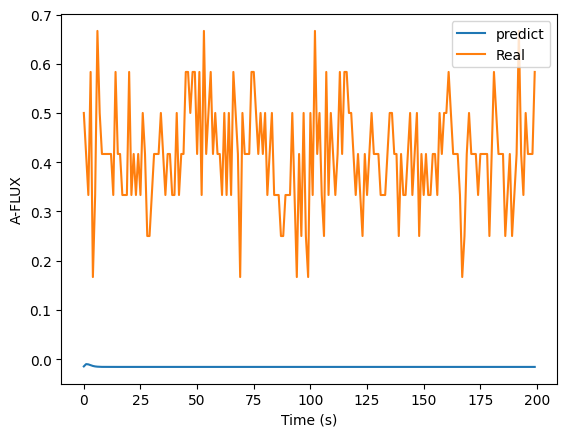

In [81]:
plt.plot(time[200:1000], predict)
plt.plot(time[200:1000], real)
plt.legend(["predict","Real"])
plt.xlabel('Time (s)')  #add x-label
plt.ylabel(features[feature_index]) #add y-label

In [60]:
from tqdm import tqdm
import random 

model.train()
with tqdm(range(epoch)) as tr:
    for i in tr:
        total_loss = 0.0
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model(x, y, ow, 0.6).to(device)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [03:53<00:00,  7.79s/it, loss=0.01760]


In [62]:
torch.save(model, './lstm_scaler.h5')

In [124]:
# torch.save(model.state_dict(),'./lstm.h5')

In [125]:
# torch.save(model, './lstm_3000.h5')

In [63]:
model_load = torch.load('./lstm_scaler.h5')

In [72]:
predict = model_load.predict(torch.tensor(train[:800]).reshape(-1,1).to(device).float(), target_len=ow)
real = train[:800]

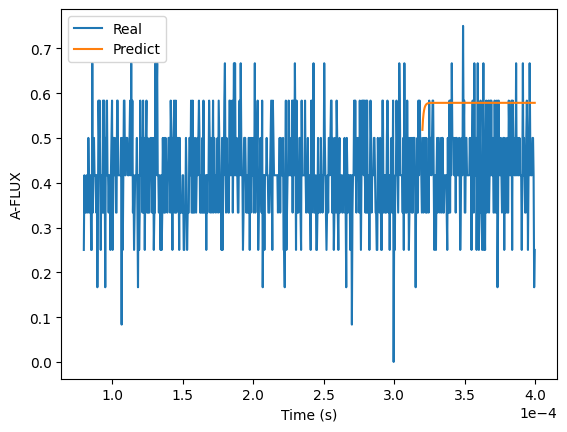

In [77]:
plt.figure()
#loop over all faulty pulses and plot the waveform given by feature_index
plt.plot(time[200:1000], real[:800])
plt.plot(time[800:1000],predict)
plt.legend(["Real","Predict"])
plt.xlabel('Time (s)')  #add x-label
plt.ylabel(features[feature_index]) #add y-label
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0)) #use sci notation
plt.show()  #show the plot

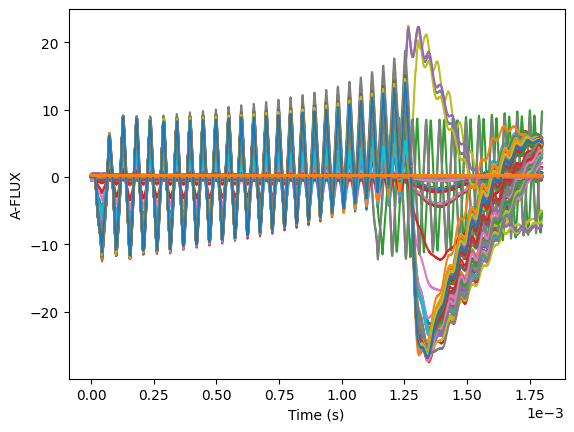

In [21]:
#plot faulty pulses
#------------------------
plt.figure()
#loop over all faulty pulses and plot the waveform given by feature_index
for i in range(Xanomaly.shape[0]):
    plt.plot(time, Xanomaly[i,:,feature_index])   #plot A-flux faults
plt.xlabel('Time (s)')  #add x-label
plt.ylabel(features[feature_index]) #add y-label
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0)) #use sci notation
plt.show()  #show the plot

In [22]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


In [23]:
Xnormal.shape

(690, 4500, 14)

In [24]:
Xnormal[:,:,6].shape

(690, 4500)

In [25]:
Ynormal[:,].shape

(690, 3)

In [26]:
Xanomaly[:,:,6].shape

(182, 4500)

In [27]:
isinstance(Xnormal, object)

True

In [28]:
for column in Ynormal.T:
    print(np.unique(column))

['./RFQ/RFQ_400ns_12_Day_Run_5.28.2022-5.08.29PM.csv'
 './RFQ/RFQ_400ns_12_Hour_Run_3.12.2022-6.23.59AM.csv'
 './RFQ/RFQ_400ns_12_Hour_Run_3.12.2022-9.00.25PM.csv'
 './RFQ/RFQ_400ns_12_Hour_Run_3.14.2022-9.50.42PM.csv'
 './RFQ/RFQ_400ns_12_Hour_Run_3.9.2022-10.21.45PM.csv'
 './RFQ/RFQ_400ns_12_Hour_Run_5.12.2022-6.44.08AM.csv'
 './RFQ/RFQ_400ns_12_Hour_Run_5.12.2022-8.21.19PM.csv'
 './RFQ/RFQ_400ns_12_Hour_Run_5.14.2022-2.00.35AM.csv'
 './RFQ/RFQ_400ns_12_Hour_Run_5.15.2022-1.27.27PM.csv'
 './RFQ/RFQ_400ns_12_Hour_Run_5.17.2022-5.08.29AM.csv'
 './RFQ/RFQ_400ns_12_Minute_Run_3.11.2022-6.35.59PM.csv'
 './RFQ/RFQ_400ns_12_Minute_Run_3.12.2022-9.12.25AM.csv'
 './RFQ/RFQ_400ns_12_Minute_Run_3.14.2022-10.02.42AM.csv'
 './RFQ/RFQ_400ns_12_Minute_Run_3.14.2022-9.37.54AM.csv'
 './RFQ/RFQ_400ns_12_Minute_Run_3.15.2022-9.50.23AM.csv'
 './RFQ/RFQ_400ns_12_Minute_Run_3.8.2022-3.32.39PM.csv'
 './RFQ/RFQ_400ns_12_Minute_Run_3.9.2022-10.33.45AM.csv'
 './RFQ/RFQ_400ns_12_Minute_Run_5.10.2022-12.45.26PM

In [29]:
for column in Yanomaly.T:
    print(np.unique(column))

['./RFQ/RFQ_400ns_Fault_1.11.2022-4.48.40PM.csv'
 './RFQ/RFQ_400ns_Fault_1.14.2022-4.03.34PM.csv'
 './RFQ/RFQ_400ns_Fault_1.27.2020-12.47.01PM.csv'
 './RFQ/RFQ_400ns_Fault_1.29.2021-3.06.43PM.csv'
 './RFQ/RFQ_400ns_Fault_1.29.2021-5.40.44PM.csv'
 './RFQ/RFQ_400ns_Fault_1.29.2021-5.47.50PM.csv'
 './RFQ/RFQ_400ns_Fault_1.29.2021-7.15.11PM.csv'
 './RFQ/RFQ_400ns_Fault_1.29.2021-7.25.48PM.csv'
 './RFQ/RFQ_400ns_Fault_1.29.2021-7.56.01PM.csv'
 './RFQ/RFQ_400ns_Fault_1.9.2020-7.39.31AM.csv'
 './RFQ/RFQ_400ns_Fault_10.1.2021-9.10.38AM.csv'
 './RFQ/RFQ_400ns_Fault_10.12.2021-1.38.07PM.csv'
 './RFQ/RFQ_400ns_Fault_10.13.2020-6.12.01PM.csv'
 './RFQ/RFQ_400ns_Fault_10.13.2020-6.16.45PM.csv'
 './RFQ/RFQ_400ns_Fault_10.13.2020-8.25.58PM.csv'
 './RFQ/RFQ_400ns_Fault_10.13.2020-8.26.38PM.csv'
 './RFQ/RFQ_400ns_Fault_10.18.2021-12.33.26PM.csv'
 './RFQ/RFQ_400ns_Fault_10.20.2021-3.23.23PM.csv'
 './RFQ/RFQ_400ns_Fault_10.20.2021-9.23.32AM.csv'
 './RFQ/RFQ_400ns_Fault_10.22.2021-3.46.05AM.csv'
 './RFQ/RF

In [30]:
for column in Yanomaly[:,2].T:
    print(np.unique(column))

['TPS Fault']
['TPS Fault']
['SNS PPS Missing']
['Fiber Fault']
['C FLUX Low Fault']
['C FLUX Low Fault']
['C FLUX Low Fault']
['C FLUX Low Fault']
['C FLUX Low Fault']
['Fiber Fault']
['SCR AC Input Fault']
['A FLUX Low Fault']
['A- Driver Fault']
['A- Driver Fault']
['A- Driver Fault']
['A- Driver Fault']
['SNS PPS Missing']
['DV/DT High Fault']
['TPS Fault']
['Fiber Fault']
['SNS PPS Missing']
['+ DC I High Fault']
['A-* Driver Fault']
['Fiber Fault']
['TPS Fault']
['+ CB V High Fault']
['Fiber Fault']
['A-* Driver Fault']
['TPS Fault']
['TPS Fault']
['A-* Driver Fault']
['DV/DT High Fault']
['DV/DT High Fault']
['A FLUX Low Fault']
['+ DC I High Fault']
['DV/DT Low Fault']
['A-* Driver Fault']
['SCR AC Input Fault']
['+ DC I High Fault']
['A-* Driver Fault']
['TPS Fault']
['SCR Firing Circ Fault']
['Dump Switch Fault']
['Dump Switch Fault']
['Dump Switch Fault']
['SCR Firing Circ Fault']
['A-* Driver Fault']
['SNS PPS Missing']
['SNS PPS Missing']
['SCR AC Input Fault']
['SNS PPS M

In [31]:
print(Ynormal.T.shape)
print(Yanomaly.T.shape)

(3, 690)
(3, 182)


In [32]:
print(Xnormal.shape)
print(Xnormal[0])
print(Ynormal.shape)
print(Ynormal[0])

(690, 4500, 14)
[[ 1.2708e+01  1.8812e+01  1.3410e+01 ... -4.6037e-02  2.1794e+03
  -4.9399e+01]
 [ 1.5150e+01  1.7591e+01  1.2190e+01 ... -4.6037e-02  2.1793e+03
  -1.0334e+01]
 [ 1.3929e+01  1.6370e+01  1.2190e+01 ...  1.5000e-02  2.1814e+03
  -1.0335e+01]
 ...
 [ 1.5150e+01  1.6370e+01  2.8059e+01 ...  1.5000e-02  2.0873e+03
   1.6520e+01]
 [ 1.6370e+01  1.6370e+01  2.8059e+01 ...  1.5000e-02  2.0888e+03
   4.3200e+00]
 [ 1.3929e+01  1.7591e+01  2.5618e+01 ... -4.6037e-02  2.0893e+03
  -1.7660e+01]]
(690, 3)
['./RFQ/RFQ_400ns_12_Day_Run_5.28.2022-5.08.29PM.csv' 'Run' 'Normal']


In [33]:
print(Xanomaly.shape)
print(Xanomaly[0])
print(Yanomaly.shape)
print(Yanomaly[0])

(182, 4500, 14)
[[-5.8370e+00 -3.3955e+00 -5.1347e+00 ... -4.6037e-02  2.2826e+03
  -1.7660e+01]
 [-7.0577e+00  1.4875e+00 -6.3555e+00 ... -1.0707e-01  2.2849e+03
  -1.2776e+01]
 [-5.8370e+00 -9.5401e-01 -3.9140e+00 ... -1.0707e-01  2.2865e+03
  -1.5218e+01]
 ...
 [-2.1747e+00 -4.6162e+00 -5.1347e+00 ...  1.5000e-02  2.2834e+03
  -5.4520e+00]
 [-4.6162e+00  2.6673e-01 -5.1347e+00 ...  1.5000e-02  2.2824e+03
  -1.2777e+01]
 [-3.3955e+00 -9.5401e-01 -7.5762e+00 ...  4.5519e-02  2.2817e+03
  -1.2777e+01]]
(182, 3)
['./RFQ/RFQ_400ns_Fault_1.11.2022-4.48.40PM.csv' 'Fault' 'TPS Fault']
